# Problem 3

*12232509 FAN Qingyuan*

---

Suppose the input source to a lossy data compression system is Gaussian with variance  $\sigma^2=100$ Write a python program to implement the Max algorithm and design an optimal scalar quantizer for $X$ . Let $\hat{x}_1,\hat{x}_2\hat{x}_3...\hat{x}_M,$ be the reconstruction levels and $D_M$ be the quantization distortion. Let $R_M$ be the entropy of the reconstruction levels. Let $M$ vary from 1 to 100. Plot the curve $R_M(D_M)$ and compare it with the theoretical rate-distortion function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from tqdm import trange

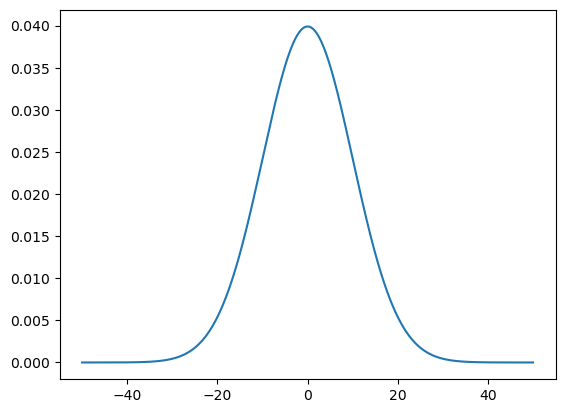

In [2]:
# generate a gaussian distribution function
sigma = 10
def gaussian(x, sigma):
    return 1 / np.sqrt(2 * np.pi * sigma**2) * np.exp(-(x)**2 / (2 * sigma**2))

# plot
x = np.linspace(-50, 50, 1000)
plt.plot(x, gaussian(x , sigma))
plt.show()

In [3]:
# def a function to determine decision levels, given sigma and level number, return an array of decision levels
def init_decision_levels(sigma, level):
    return np.linspace(-3*sigma, 3*sigma, level)

# def a function to return the reconstruction levels by given decision levels
def calc_reconstruction_levels(decision_level_L, decision_level_R):
    # return the gravity center of the decision levels
    return integrate.quad(lambda x: x * gaussian(x, sigma), decision_level_L, decision_level_R)[0] / integrate.quad(lambda x: gaussian(x, sigma), decision_level_L, decision_level_R)[0]

# def a function to calculate the reconstruction distortion
def calc_reconstruction_distortion(decision_level_L, decision_level_R, reconstruction_level):
    # return the integral of the square of the difference between the reconstruction level and the original signal
    return integrate.quad(lambda x: (x - reconstruction_level)**2 * gaussian(x, sigma), decision_level_L, decision_level_R)[0]

def update_decision_level(mid_point):
    return (mid_point[0] + mid_point[1]) / 2

def calc_entropy(decision_levels):
    # calculate the entropy of reconstruction levels
    entropy = 0
    # use 4 sigma as boundary, as the gaussian distribution is almost 0 outside 4 sigma and scipy integrate.quad cannot handle infinite boundary in some cases

    for i in range(len(decision_levels)+1):
        if i == 0:
            entropy -= (integrate.quad(lambda x: gaussian(x, sigma), -4*sigma, decision_levels[i])[0] * np.log2(integrate.quad(lambda x: gaussian(x, sigma), -4*sigma, decision_levels[i])[0]))
        elif i == len(decision_levels):
            entropy -= (integrate.quad(lambda x: gaussian(x, sigma), decision_levels[i-1], 4*sigma)[0] * np.log2(integrate.quad(lambda x: gaussian(x, sigma), decision_levels[i-1], 4*sigma)[0]))
        else:
            entropy -= (integrate.quad(lambda x: gaussian(x, sigma),  decision_levels[i-1], decision_levels[i])[0] * np.log2(integrate.quad(lambda x: gaussian(x, sigma), decision_levels[i-1], decision_levels[i])[0]))
    return entropy


In [4]:
def quantization(decision_level_number, loss_limit):
    decision_levels = init_decision_levels(sigma, decision_level_number)
    reconstruction_level = np.zeros(len(decision_levels)+1)
    distortion = 0
    loss = 1
    while loss >= loss_limit:
        # STEP 2 calculate the reconstruction levels
        for i in range(len(decision_levels)+1):
            if i == 0:
                reconstruction_level[i] = calc_reconstruction_levels(-np.inf, decision_levels[i])
            elif i == len(decision_levels):
                reconstruction_level[i] = calc_reconstruction_levels(decision_levels[i-1], np.inf)
            else:
                reconstruction_level[i] = calc_reconstruction_levels(decision_levels[i-1], decision_levels[i])

        # STEP 3 update the decision levels
        for i in range(len(decision_levels)):
            decision_levels[i] = (reconstruction_level[i] + reconstruction_level[i+1]) / 2

        # STEP 4 calculate the reconstruction distortion
        reconstruction_distortion_s = 0
        for i in range(len(decision_levels)+1):
            if i == 0:
                reconstruction_distortion_s += calc_reconstruction_distortion(-np.inf, decision_levels[i], reconstruction_level[i])
            elif i == len(decision_levels):
                reconstruction_distortion_s += calc_reconstruction_distortion(decision_levels[i-1], np.inf, reconstruction_level[i])
            else:
                reconstruction_distortion_s += calc_reconstruction_distortion(decision_levels[i-1], decision_levels[i], reconstruction_level[i])
        loss = (distortion - reconstruction_distortion_s)/reconstruction_distortion_s
        distortion = reconstruction_distortion_s
        entropy = calc_entropy(decision_levels)

        
    return entropy, distortion

In [5]:
quantization(1, 1E-20)

(0.28877544422943713, 86.08208106849129)

In [6]:
RM_DM_arr = np.zeros([99,3]) # No, R, D
for i in trange(1,100):
    RM_DM_arr[i-1,0] = i
    RM_DM_arr[i-1,1] , RM_DM_arr[i-1,2] = quantization(i,0)


100%|██████████| 99/99 [00:01<00:00, 86.00it/s] 


## Plot the $R_M(D_M)$ figure.

The curve $R_M(D_M)$ is plotted below. The curve is very close to the theoretical rate-distortion function.

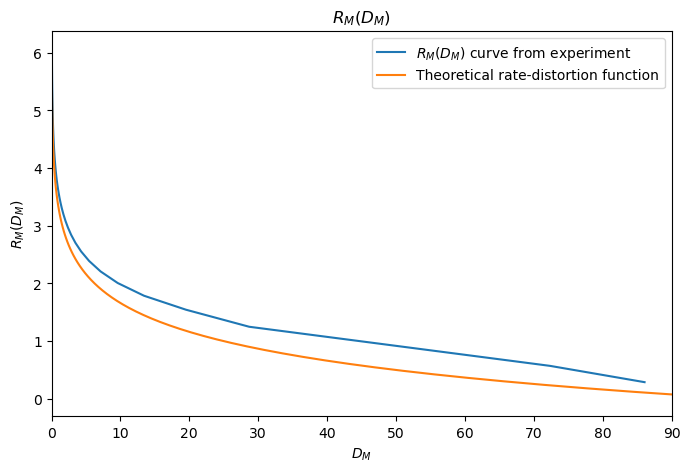

In [7]:
# set size of figure
plt.figure(figsize=(8,5))
#plt.scatter(RM_DM_arr.T[2],RM_DM_arr.T[1])
plt.plot(RM_DM_arr.T[2],RM_DM_arr.T[1])

# plot the theoretical rate-distortion function
R = np.linspace(0, 6, 100)
D = np.power(sigma,2) * np.power(2, -2*R)
plt.plot(D,R)
plt.xlabel('$D_M$')
plt.ylabel('$R_M(D_M)$')
plt.title('$R_M(D_M)$')

# add legend
plt.legend(['$R_M(D_M)$ curve from experiment', 'Theoretical rate-distortion function'])
plt.xlim(0, 90)
plt.show()
